In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li, div.text_cell_render ol li p, code{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

# <span style="color:red">ch5_LSTM(RNN,GRU)으로 영화평 구분하기</span>
- imdb사이트의 5만개 영화 감상평 : train/test - 타겟변수

In [6]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time #유닉스 time을 계산하기 위해

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense

from sklearn.metrics import confusion_matrix. recall_score, precision_score, f1_score
from pandas import crosstab

# 2. 하이퍼파라미터 설정
- 하이퍼파라미터를 바꾸면 모델의 정확도나 속도에 차이남

In [7]:
MY_WORDS  = 10000 # imdb 데이타 안의 단어 수
MY_LENGTH = 80    # 독립변수 차원(영화평 단어수 80개도 맞출 예정)
MY_EMBED  = 32    # 임베딩 결과 차원
MY_HIDDEN = 64    # LSTM의 유닛수

MY_EPOCH = 10     # fit 반복학습수
MY_BATCH = 200    # 배치사이즈(fit할 때, 매버 기져오는 데이터 수)

# 3. 데이터 불러오기

In [8]:
(X_train, y_train), (X_test, y_test)=imdb.load_data(num_words=MY_WORDS)

17464789/17464789 [==============================] - 1s 0us/step


In [11]:
print('학습용 독립변수 모양 :', X_train.shape)
print('학습용 타겟변수 모양 :', y_train.shape)
print('학습용 독립변수 샘플 :', X_train[0][:80])
print('학습용 타겟변수(0:부정/1:긍정) 샘플 :', y_train[0])
print('테스트용 독립변수 모양 :', X_test.shape)
print('테스트용 타겟변수 모양 :', y_test.shape)

학습용 독립변수 모양 : (25000,)
학습용 타겟변수 모양 : (25000,)
학습용 독립변수 샘플 : [1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17]
학습용 타겟변수(0:부정/1:긍정) 샘플 : 1
테스트용 독립변수 모양 : (25000,)
테스트용 타겟변수 모양 : (25000,)


In [18]:
# 부/긍정 갯수
import pandas as pd
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    12500
0    12500
dtype: int64
0    12500
1    12500
dtype: int64


In [19]:
# 긍정 갯수
print('학습데이터의 긍정 갯수 :', y_train.sum())
print('테스트데이터의 긍정 갯수 :', y_test.sum())

학습데이터의 긍정 갯수 : 12500
테스트데이터의 긍정 갯수 : 12500


# 4. 문자단어 -> 정수

In [22]:
word_to_id = imdb.get_word_index() # 빈도가 높은 단어는 앞
print(word_to_id['movie'])
print(word_to_id.get('film'))
print(word_to_id['the'])
# 정수 -> 문자 단어
id_to_word = {}
for key, value in word_to_id.items():
        id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))
print(id_to_word.get(1))

17
19
1
movie
film
the


In [24]:
msg = "What a wonderful movieabdbdsb"
msg = msg.lower().split()
print(msg)
# 1: 리뷰의 시작을 알리는 숫자 2: MY_WORDS(10000)이내에 들어가지 않는 단어, 3:padding처리
data = [1]+[word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용 :', msg)
print('encoded된 내용(data) :', data)
print('data 추정 :', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'movieabdbdsb']
원 후기 내용 : ['what', 'a', 'wonderful', 'movieabdbdsb']
encoded된 내용(data) : [1, 51, 6, 389, 2]
data 추정 : ??? what a wonderful ???


In [25]:
[id_to_word.get(d-3, '???') for d in data]

['???', 'what', 'a', 'wonderful', '???']

# 5. 숫자영화평 -> 자연어 영화평 함수

In [28]:
def decoding(review_nums):
    decoded = [] # 숫자를 단어로 해석한 내용 append
    print(review_nums)

In [29]:
decoding(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


# 6. 영화평 학습용 데이터 처음 10개의 길이 출력 함수

In [31]:
def show_length():
    print('첫 20개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이 :{len(X_train[i])}')
    print([len(x) for x in X_train[:21]])
show_length()

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [32]:
print('pad_sequence 작업전')
show_length()

pad_sequence 작업전
첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [33]:
# X_train 후기 중 가장 긴 단어수, 가장 짧은 단어수
max([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

# 7. 모든 영화평의 길이를 동일하게(MY_LENGTH만큼)

In [34]:
X_train = pad_sequences(X_train,
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       padding='post',
                       #padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                     )
X_test = pad_sequences(X_test, 
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       padding='post',
                       # padding='pre' 
                    )
show_length()

첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


# 8. 최종 데이터 shape 확인

In [35]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 80), (25000,), (25000, 80), (25000,))

In [36]:
decoding(X_train[0])

[  1  14  22  16  43 530 973   2   2  65 458   2  66   2   4 173  36 256
   5  25 100  43 838 112  50 670   2   9  35 480 284   5 150   4 172 112
 167   2 336 385  39   4 172   2   2  17 546  38  13 447   4 192  50  16
   6 147   2  19  14  22   4   2   2 469   4  22  71  87  12  16  43 530
  38  76  15  13   2   4  22  17]


# 9. 모델 생성 및 구현

In [38]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS,  # 10000
                    output_dim=MY_EMBED, # 32
                    input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN,
              input_shape=(MY_LENGTH, MY_EMBED),
              # kernel_initializer='he_normal' , #입력 가중치 초기화
              # recurrent_initializer= 'orthogonal' # 순환 가중치 초기화
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            32000     
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 56,897
Trainable params: 56,897
Non-trainable params: 0
_________________________________________________________________


# 10. 학습환경 설정 및 학습하기

In [39]:
model.compile(loss='binary_crossentropy', # 이중분류(로지스틱회귀분석)
              optimizer='adam',
              metrics=['acc']
             )
start = time() # 70.1.1 ~ 이 시점까지 초수
hist = model.fit(X_train, y_train,
                epochs=MY_EPOCH,
                batch_size=MY_BATCH,
                validation_split=0.2,
                verbose=1)
end = time() # 70.1.1 ~ 이 시점까지 초수
print('총 fit 시간 : {:.5f}'.format(end-start))

Epoch 1/10
100/100 [==============================] - 9s 75ms/step - loss: 0.6137 - acc: 0.6453 - val_loss: 0.4981 - val_acc: 0.7610
Epoch 2/10
100/100 [==============================] - 7s 70ms/step - loss: 0.4722 - acc: 0.7757 - val_loss: 0.4679 - val_acc: 0.7804
Epoch 3/10
100/100 [==============================] - 7s 69ms/step - loss: 0.4475 - acc: 0.7907 - val_loss: 0.4602 - val_acc: 0.7842
Epoch 4/10
100/100 [==============================] - 7s 72ms/step - loss: 0.4416 - acc: 0.7926 - val_loss: 0.4601 - val_acc: 0.7854
Epoch 5/10
100/100 [==============================] - 7s 72ms/step - loss: 0.4389 - acc: 0.7959 - val_loss: 0.4655 - val_acc: 0.7828
Epoch 6/10
100/100 [==============================] - 7s 71ms/step - loss: 0.4359 - acc: 0.7972 - val_loss: 0.4591 - val_acc: 0.7794
Epoch 7/10
100/100 [==============================] - 7s 71ms/step - loss: 0.4295 - acc: 0.7998 - val_loss: 0.4625 - val_acc: 0.7838
Epoch 8/10
100/100 [==============================] - 7s 71ms/step - 

# 11. 모델평가 

In [40]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

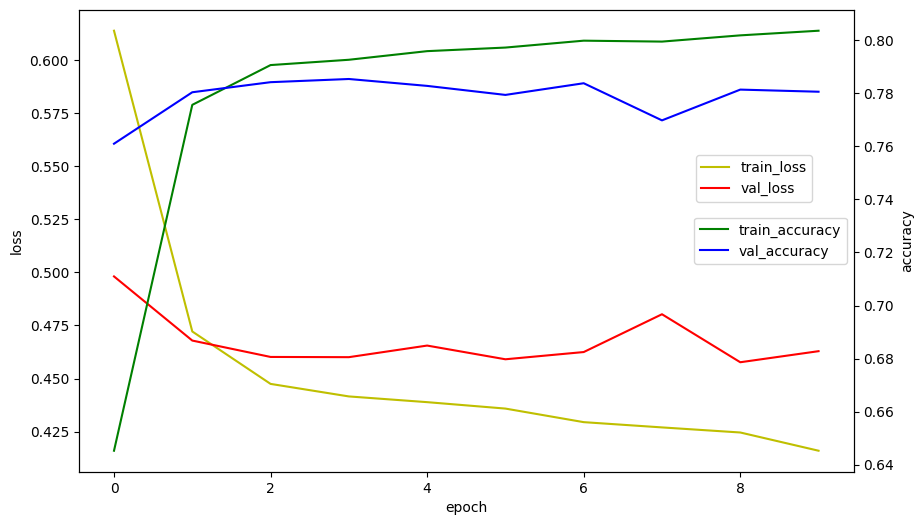

In [41]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [42]:
# 테스트 데이터로 평가
loss, acc = model.evaluate(X_test, y_test)

782/782 [==============================] - 7s 8ms/step - loss: 0.4631 - acc: 0.7792
